# Experimentacion

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
import tqdm

In [2]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [3]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

datasets = os.listdir("./data/")
print(datasets)
datasets = datasets[1:]
print(datasets)

./../codigo/build/ContarPalabras
['incremental', 'normal.txt', 'uniforme.txt']
['normal.txt', 'uniforme.txt']


In [ ]:
threads = [1,2,3,4,5,6,7,8,10,15,20,25,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/uniforme.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/uniforme.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
print(dfExp)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).mean().reset_index()
#result['time'] = result.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
print(result)
ax= sns.pointplot(data=result[(result.algorithm == 'maximoParalelo')], x='cantThreads', y='time',hue="algorithm", ci=None)

 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (!prev)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (!prev)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (!prev)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
free(): corrupted unsorted chunks


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
malloc(): unsorted double linked list corrupted
double free or corruption (!prev)
double free or corruption (out)
free(): invalid pointer
free(): invalid pointer
free(): invalid pointer
free(): invalid pointer


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (!prev)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (!prev)
double free or corruption (out)
malloc(): unsorted double linked list corrupted
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
ContarPalabras: malloc.c:2617: sysmalloc: Assertion `(old_top == initial_top (av) && old_size == 0) || ((unsigned long) (old_size) >= MINSIZE && prev_inuse (old_top) && ((unsigned long) old_end & (pagesize - 1)) == 0)' failed.
double free or corruption (out)
double free or corruption (!prev)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (!prev)
double free or corruption (out)


 ./data/incremental/uniforme50/uniforme50_0.txt ./data/incremental/uniforme50/uniforme50_1.txt ./data/incremental/uniforme50/uniforme50_10.txt ./data/incremental/uniforme50/uniforme50_11.txt ./data/incremental/uniforme50/uniforme50_12.txt ./data/incremental/uniforme50/uniforme50_13.txt ./data/incremental/uniforme50/uniforme50_14.txt ./data/incremental/uniforme50/uniforme50_15.txt ./data/incremental/uniforme50/uniforme50_16.txt ./data/incremental/uniforme50/uniforme50_17.txt ./data/incremental/uniforme50/uniforme50_18.txt ./data/incremental/uniforme50/uniforme50_19.txt ./data/incremental/uniforme50/uniforme50_2.txt ./data/incremental/uniforme50/uniforme50_20.txt ./data/incremental/uniforme50/uniforme50_21.txt ./data/incremental/uniforme50/uniforme50_22.txt ./data/incremental/uniforme50/uniforme50_23.txt ./data/incremental/uniforme50/uniforme50_24.txt ./data/incremental/uniforme50/uniforme50_25.txt ./data/incremental/uniforme50/uniforme50_3.txt ./data/incremental/uniforme50/uniforme50_4.

double free or corruption (out)
double free or corruption (out)
double free or corruption (!prev)
double free or corruption (out)
double free or corruption (out)
double free or corruption (out)


   cantThreads  sec       ns                algorithm
0            1    0  3863170  cargarMultiplesArchivos
1            1    0    66063           maximoParalelo
0            1    0  2124535  cargarMultiplesArchivos
1            1    0    67711           maximoParalelo
0            1    0  2512862  cargarMultiplesArchivos
1            1    0   100785           maximoParalelo
0            1    0  1974722  cargarMultiplesArchivos
1            1    0    51843           maximoParalelo
0            1    0  2063228  cargarMultiplesArchivos
1            1    0    92245           maximoParalelo
0            1    0  1956376  cargarMultiplesArchivos
1            1    0   103163           maximoParalelo
0            1    0  1905750  cargarMultiplesArchivos
1            1    0    41348           maximoParalelo
0            1    0  2198916  cargarMultiplesArchivos
1            1    0    68973           maximoParalelo
0            1    0  1898432  cargarMultiplesArchivos
1            1    0    71726

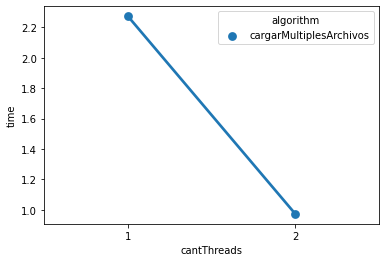

In [7]:
threads = [1,2,3,4,5,6,7,8]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/uniforme.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = ""
    for file in os.listdir("./data/incremental/uniforme50"):
            args += " ./data/incremental/uniforme50/" + file
    
    print (args)
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
print(dfExp)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).mean().reset_index()
print(result)
ax= sns.pointplot(data=result[(result.algorithm == 'cargarMultiplesArchivos')], x='cantThreads', y='time',hue="algorithm", ci=None)